## 1. Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader

## 2. 하이퍼파라미터 세팅

In [9]:
TRAIN_PATH = "./train.csv"
BATCH_SIZE = 64
EPOCHS = 5
# LR = 1e-3
LR = 3e-3
HIDDEN_DIM = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cpu


## 3. 데이터 로드 및 전처리
### - 에피소드 별 (x,y) 시퀀스 생성

In [10]:
df = pd.read_csv("./train.csv")
df = df.sort_values(["game_episode", "time_seconds"]).reset_index(drop=True)

episodes = []
targets = []

for _, g in tqdm(df.groupby("game_episode")):
    g = g.reset_index(drop=True)
    if len(g) < 2:
        continue

    # 정규화된 좌표 준비
    sx = g["start_x"].values / 105.0
    sy = g["start_y"].values / 68.0
    ex = g["end_x"].values   / 105.0
    ey = g["end_y"].values   / 68.0

    coords = []
    for i in range(len(g)):
        # 항상 start는 들어감
        coords.append([sx[i], sy[i]])
        # 마지막 행 이전까지만 end를 넣음 (마지막 end는 타깃이므로)
        if i < len(g) - 1:
            coords.append([ex[i], ey[i]])

    seq = np.array(coords, dtype="float32")        # [T, 2]
    target = np.array([ex[-1], ey[-1]], dtype="float32")  # 마지막 행 end_x, end_y

    episodes.append(seq)
    targets.append(target)

print("에피소드 수 : ", len(episodes))

100%|██████████| 15435/15435 [00:04<00:00, 3509.07it/s]

에피소드 수 :  15428


## 4. Custom Dataset / DataLoader 정의 및 Validation 분할

In [11]:
class EpisodeDataset(Dataset):
    def __init__(self, episodes, targets):
        self.episodes = episodes
        self.targets = targets

    def __len__(self):
        return len(self.episodes)

    def __getitem__(self, idx):
        seq = torch.tensor(self.episodes[idx])   # [T, 2]
        tgt = torch.tensor(self.targets[idx])    # [2]
        length = seq.size(0)
        return seq, length, tgt

def collate_fn(batch):
    seqs, lengths, tgts = zip(*batch)
    lengths = torch.tensor(lengths, dtype=torch.long)
    padded = pad_sequence(seqs, batch_first=True)  # [B, T, 2]
    tgts = torch.stack(tgts, dim=0)                # [B, 2]
    return padded, lengths, tgts

# 에피소드 단위 train / valid split
idx_train, idx_valid = train_test_split(
    np.arange(len(episodes)), test_size=0.2, random_state=42
)

episodes_train = [episodes[i] for i in idx_train]
targets_train  = [targets[i]  for i in idx_train]
episodes_valid = [episodes[i] for i in idx_valid]
targets_valid  = [targets[i]  for i in idx_valid]

train_loader = DataLoader(
    EpisodeDataset(episodes_train, targets_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)

valid_loader = DataLoader(
    EpisodeDataset(episodes_valid, targets_valid),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

print("train episodes:", len(episodes_train), "valid episodes:", len(episodes_valid))

train episodes: 12342 valid episodes: 3086


## 5. LSTM 베이스라인 모델 정의

In [12]:
class LSTMBaseline(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, 2)  # (x_norm, y_norm)

    def forward(self, x, lengths):
        # x: [B, T, 2], lengths: [B]
        packed = pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed)
        h_last = h_n[-1]      # [B, H] 마지막 layer의 hidden state
        out = self.fc(h_last) # [B, 2]
        return out

model = LSTMBaseline(input_dim=2, hidden_dim=HIDDEN_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## 6. 모델 학습 및 검증

In [13]:
best_dist = float("inf")
best_model_state = None

for epoch in range(1, EPOCHS + 1):
    # --- Train ---
    model.train()
    total_loss = 0.0

    for X, lengths, y in tqdm(train_loader):
        X, lengths, y = X.to(DEVICE), lengths.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()  # 이전 batch 에서 누적된 grad 제거
        pred = model(X, lengths)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)

    train_loss = total_loss / len(train_loader.dataset)

    # --- Valid: 평균 유클리드 거리 ---
    model.eval()
    dists = []

    with torch.no_grad():
        for X, lengths, y in tqdm(valid_loader):
            X, lengths, y = X.to(DEVICE), lengths.to(DEVICE), y.to(DEVICE)
            pred = model(X, lengths)

            pred_np = pred.cpu().numpy()
            true_np = y.cpu().numpy()

            pred_x = pred_np[:, 0] * 105.0
            pred_y = pred_np[:, 1] * 68.0
            true_x = true_np[:, 0] * 105.0
            true_y = true_np[:, 1] * 68.0

            dist = np.sqrt((pred_x - true_x) ** 2 + (pred_y - true_y) ** 2)
            dists.append(dist)

    mean_dist = np.concatenate(dists).mean()  # 평균 유클리드 거리

    print(
        f"[Epoch {epoch}] "
        f"train_loss={train_loss:.4f} | "
        f"valid_mean_dist={mean_dist:.4f}"
    )

    # ----- BEST MODEL 업데이트 -----
    if mean_dist < best_dist:
        best_dist = mean_dist
        best_model_state = model.state_dict().copy()
        print(f" --> Best model updated! (dist={best_dist:.4f})")

  0%|          | 0/193 [00:00<?, ?it/s]

[Epoch 1] train_loss=0.0598 | valid_mean_dist=18.2398
 --> Best model updated! (dist=18.2398)


  0%|          | 0/193 [00:00<?, ?it/s]

[Epoch 2] train_loss=0.0337 | valid_mean_dist=17.9234
 --> Best model updated! (dist=17.9234)


  0%|          | 0/193 [00:00<?, ?it/s]

[Epoch 3] train_loss=0.0326 | valid_mean_dist=17.3929
 --> Best model updated! (dist=17.3929)


  0%|          | 0/193 [00:00<?, ?it/s]

[Epoch 4] train_loss=0.0322 | valid_mean_dist=17.6139


100%|██████████| 49/49 [00:00<00:00, 51.85it/s]

[Epoch 5] train_loss=0.0321 | valid_mean_dist=17.3155
 --> Best model updated! (dist=17.3155)


## 7. 평가 데이터셋 추론

In [14]:
# Best Model Load
model.load_state_dict(best_model_state)
model.eval()

test_meta = pd.read_csv("./test.csv")
submission = pd.read_csv("./sample_submission.csv")

submission = submission.merge(test_meta, on="game_episode", how="left")

preds_x, preds_y = [], []

for _, row in tqdm(submission.iterrows(), total=len(submission)):
    g = pd.read_csv(row["path"]).reset_index(drop=True)
    # 정규화된 좌표 준비
    sx = g["start_x"].values / 105.0
    sy = g["start_y"].values / 68.0
    ex = g["end_x"].values / 105.0
    ey = g["end_y"].values / 68.0
    
    coords = []
    for i in range(len(g)):
        # start는 항상 존재하므로 그대로 사용
        coords.append([sx[i], sy[i]])
        # 마지막 행은 end_x가 NaN이므로 자동으로 제외됨
        if i < len(g) - 1:
            coords.append([ex[i], ey[i]])

    seq = np.array(coords, dtype="float32")  # [T, 2]

    x = torch.tensor(seq).unsqueeze(0).to(DEVICE)      # [1, T, 2]
    length = torch.tensor([seq.shape[0]]).to(DEVICE)   # [1]

    with torch.no_grad():
        pred = model(x, length).cpu().numpy()[0]       # [2], 정규화 좌표

    preds_x.append(pred[0] * 105.0)
    preds_y.append(pred[1] * 68.0)
print("Inference Done.")

100%|██████████| 2414/2414 [00:13<00:00, 173.68it/s]

Inference Done.


## 8. 제출 Submission 생성

In [15]:
submission["end_x"] = preds_x
submission["end_y"] = preds_y
submission[["game_episode", "end_x", "end_y"]].to_csv("./submission/baseline_tunning2.csv", index=False)


## 시각화 해보기

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pred_df = pd.read_csv("./submission/baseline_submit.csv")
preds = pred_df[["end_x", "end_y"]].values  # (N, 2)

In [21]:
def plot_episode(episode_seq, true_target, pred_target, episode_id=None):
    """
    episode_seq : [T, 2]  (정규화 좌표)
    true_target : [2]
    pred_target : [2]
    """

    # 실제 좌표로 복원
    seq_x = episode_seq[:, 0] * 105
    seq_y = episode_seq[:, 1] * 68

    true_x, true_y = true_target[0] * 105, true_target[1] * 68
    pred_x, pred_y = pred_target[0] , pred_target[1]

    plt.figure(figsize=(10, 6))

    # 패스 흐름
    plt.plot(seq_x, seq_y, "-o", alpha=0.7, label="Pass sequence")

    # 시작점
    plt.scatter(seq_x[0], seq_y[0], c="green", s=100, label="Start")

    # 실제 마지막 패스
    plt.scatter(true_x, true_y, c="blue", s=120, marker="*", label="True final pass")

    # 예측 마지막 패스
    plt.scatter(pred_x, pred_y, c="red", s=120, marker="X", label="Predicted final pass")

    # 경기장 비율 유지
    plt.xlim(0, 105)
    plt.ylim(0, 68)
    plt.gca().set_aspect("equal", adjustable="box")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Episode {episode_id}" if episode_id is not None else "Episode visualization")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.show()

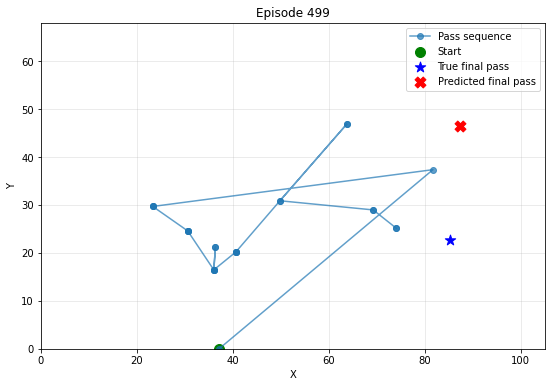

In [25]:
idx = 499

plot_episode(
    episode_seq=episodes[idx],
    true_target=targets[idx],
    pred_target=preds[idx],
    episode_id=idx
)